# Titov Ilya GNN in the SNA

### Course Work 2022: Detection bot in social graph in VK

In [1]:
import pandas as pd
import requests
import networkx
import time
import numpy as np
import collections
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz
import matplotlib.pyplot as plt

### Конфиг подключения VK API

In [2]:
class Config():
    access_t = '***********'
    vk_api_version = '5.131'

### Получаем информацию о друзьях пользователя

In [3]:
def get_friends_ids(user_id: str, with_name: bool = True):
    fields = 'first_name,last_name' if with_name else ''
    friends_url = 'https://api.vk.com/method/friends.get?' + \
    'user_id={}&v={}&fields={}&access_token={}'.format(int(user_id), Config.vk_api_version, fields, Config.access_t)
    json_response = requests.get(friends_url).json()
    if json_response.get('error'):
        print(json_response.get('error'))
        return list()
    return json_response[u'response']

In [4]:
MAIN_USER_ID = 538148234
main_users_pure = get_friends_ids(MAIN_USER_ID, with_name=True)
main_users = {user_dict['id']: [user_dict.get('first_name') + \
                ' ' + user_dict.get('last_name'), user_dict.get('is_closed')] for user_dict in main_users_pure['items']}
main_users[MAIN_USER_ID] = ['Я', False]

In [5]:
graph = {}
print("Started")
for user in main_users.items():
    if user[1][1] == False:
        graph[user[0]] = get_friends_ids(user[0])['items']
print("Finished")

Started
Finished


In [6]:
unique_users = set(graph.keys())
for user_friends in graph.values():
    for user in user_friends:
        unique_users.add(user['id'])
print('Всего получено различных пользователей ВКонтакте:', len(unique_users))

Всего получено различных пользователей ВКонтакте: 50861


## Формируем граф

### С центральной вершиной

In [7]:
g = networkx.Graph()
for user_id, user_friends in graph.items():
    g.add_node(main_users[user_id][0])
    for friend_id in user_friends:
        if friend_id['id'] in main_users:
            g.add_edge(main_users[user_id][0], main_users[friend_id['id']][0])

In [8]:
def graph_descr(g):
    print('Вершины графа:\n')
    print('Количество -', g.number_of_nodes())
    print('Средний кластерный коэффициент -', \
          np.average(np.array(list(networkx.clustering(g).values()))))
    print('Средняя степень -', \
          np.average(np.array([degree for user_name_, degree in networkx.degree(g)])))
graph_descr(g)

Вершины графа:

Количество - 234
Средний кластерный коэффициент - 0.621894090309894
Средняя степень - 8.23076923076923


### Разделяем на кластеры с помощью Clauset-Newman-Moore greedy modularity

In [29]:
from random import randint
import copy

In [34]:
def get_rand_color() -> str:
    col = lambda: randint(0,255)
    return ('#%02X%02X%02X' % (col(),col(),col()))
get_rand_color()

'#85BB11'

In [9]:

g_new = copy.deepcopy(g)
g_new.remove_node(main_users[MAIN_USER_ID][0])

In [10]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
c = list(greedy_modularity_communities(g_new))
print('Количество разделение по кластерам: {}'.format(len(c)))

Количество разделение по кластерам: 19


### Визуализируем граф

In [39]:
def graph_plot(g):
    plt.figure(figsize=(30, 30))
    circ_pos = networkx.kamada_kawai_layout(g)
    for community in c:
        networkx.draw(g, circ_pos, nodelist=community, node_color=get_rand_color(), alpha=0.5, with_labels=True, width=0.5, node_size=1000, font_size=16)
    plt.show()

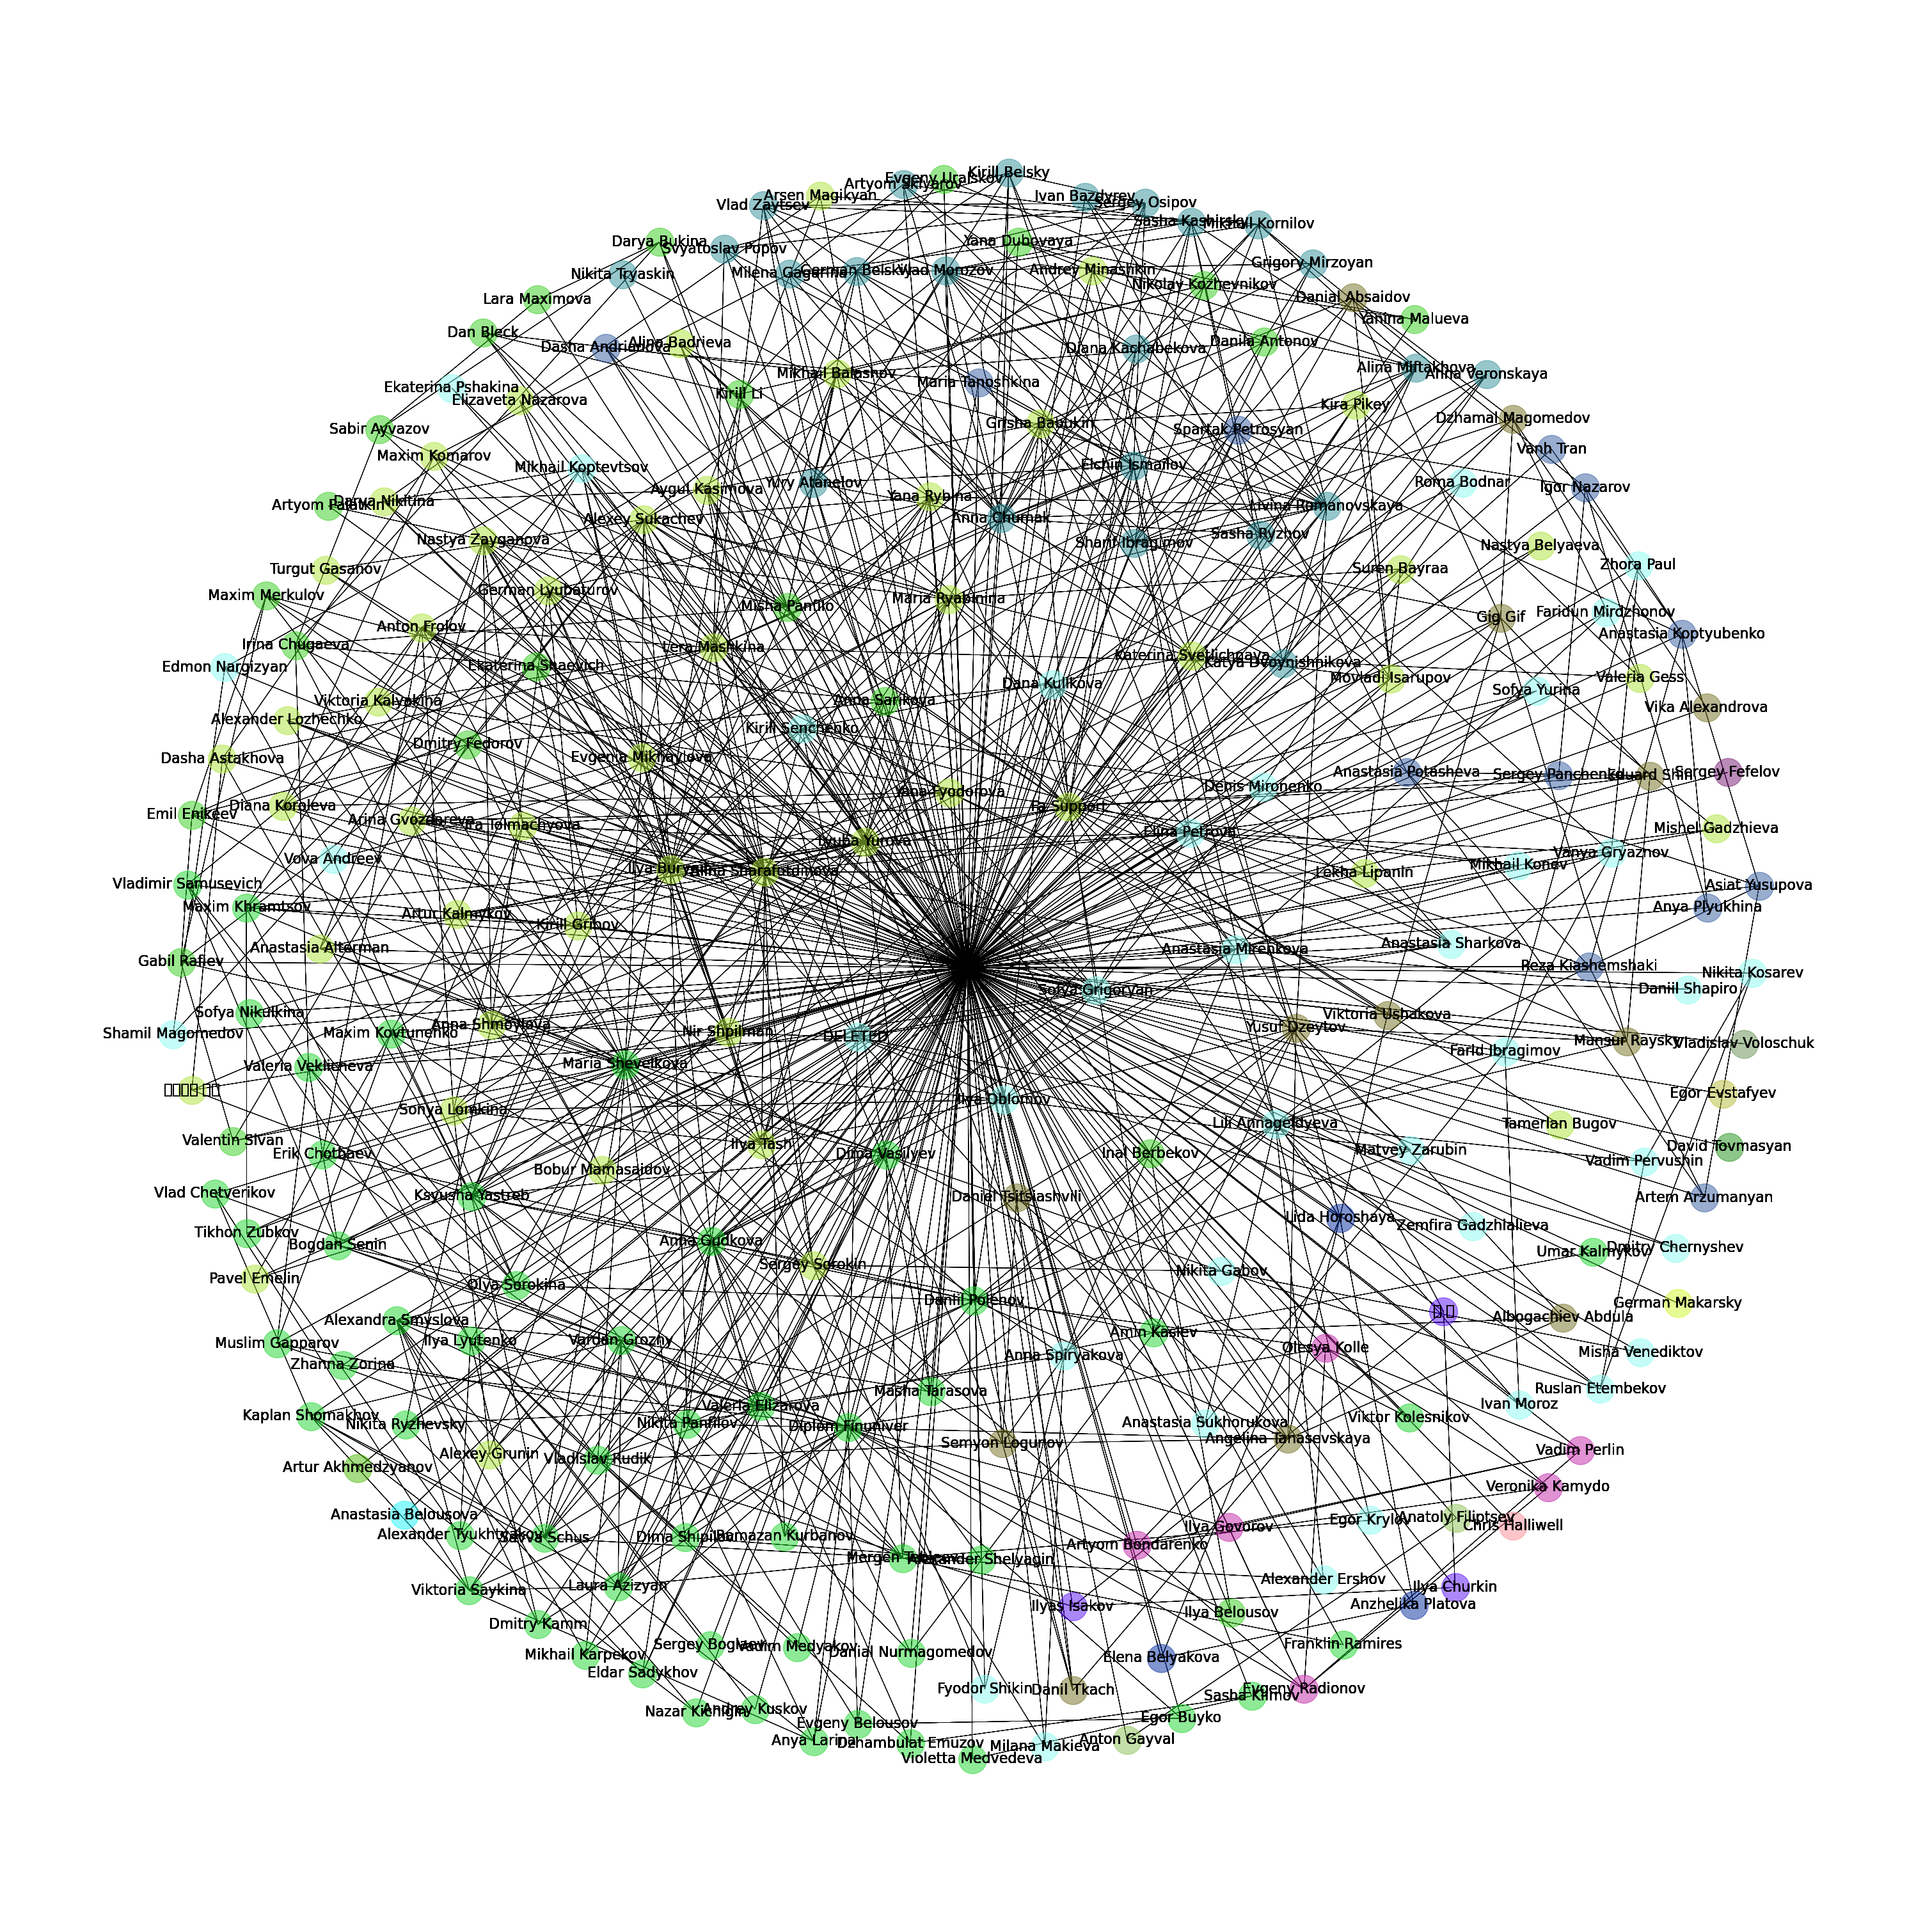

In [40]:
graph_plot(g)

### Без центра

In [41]:
graph_descr(g_new)

Вершины графа:

Количество - 233
Средний кластерный коэффициент - 0.38104570990425735
Средняя степень - 6.266094420600858


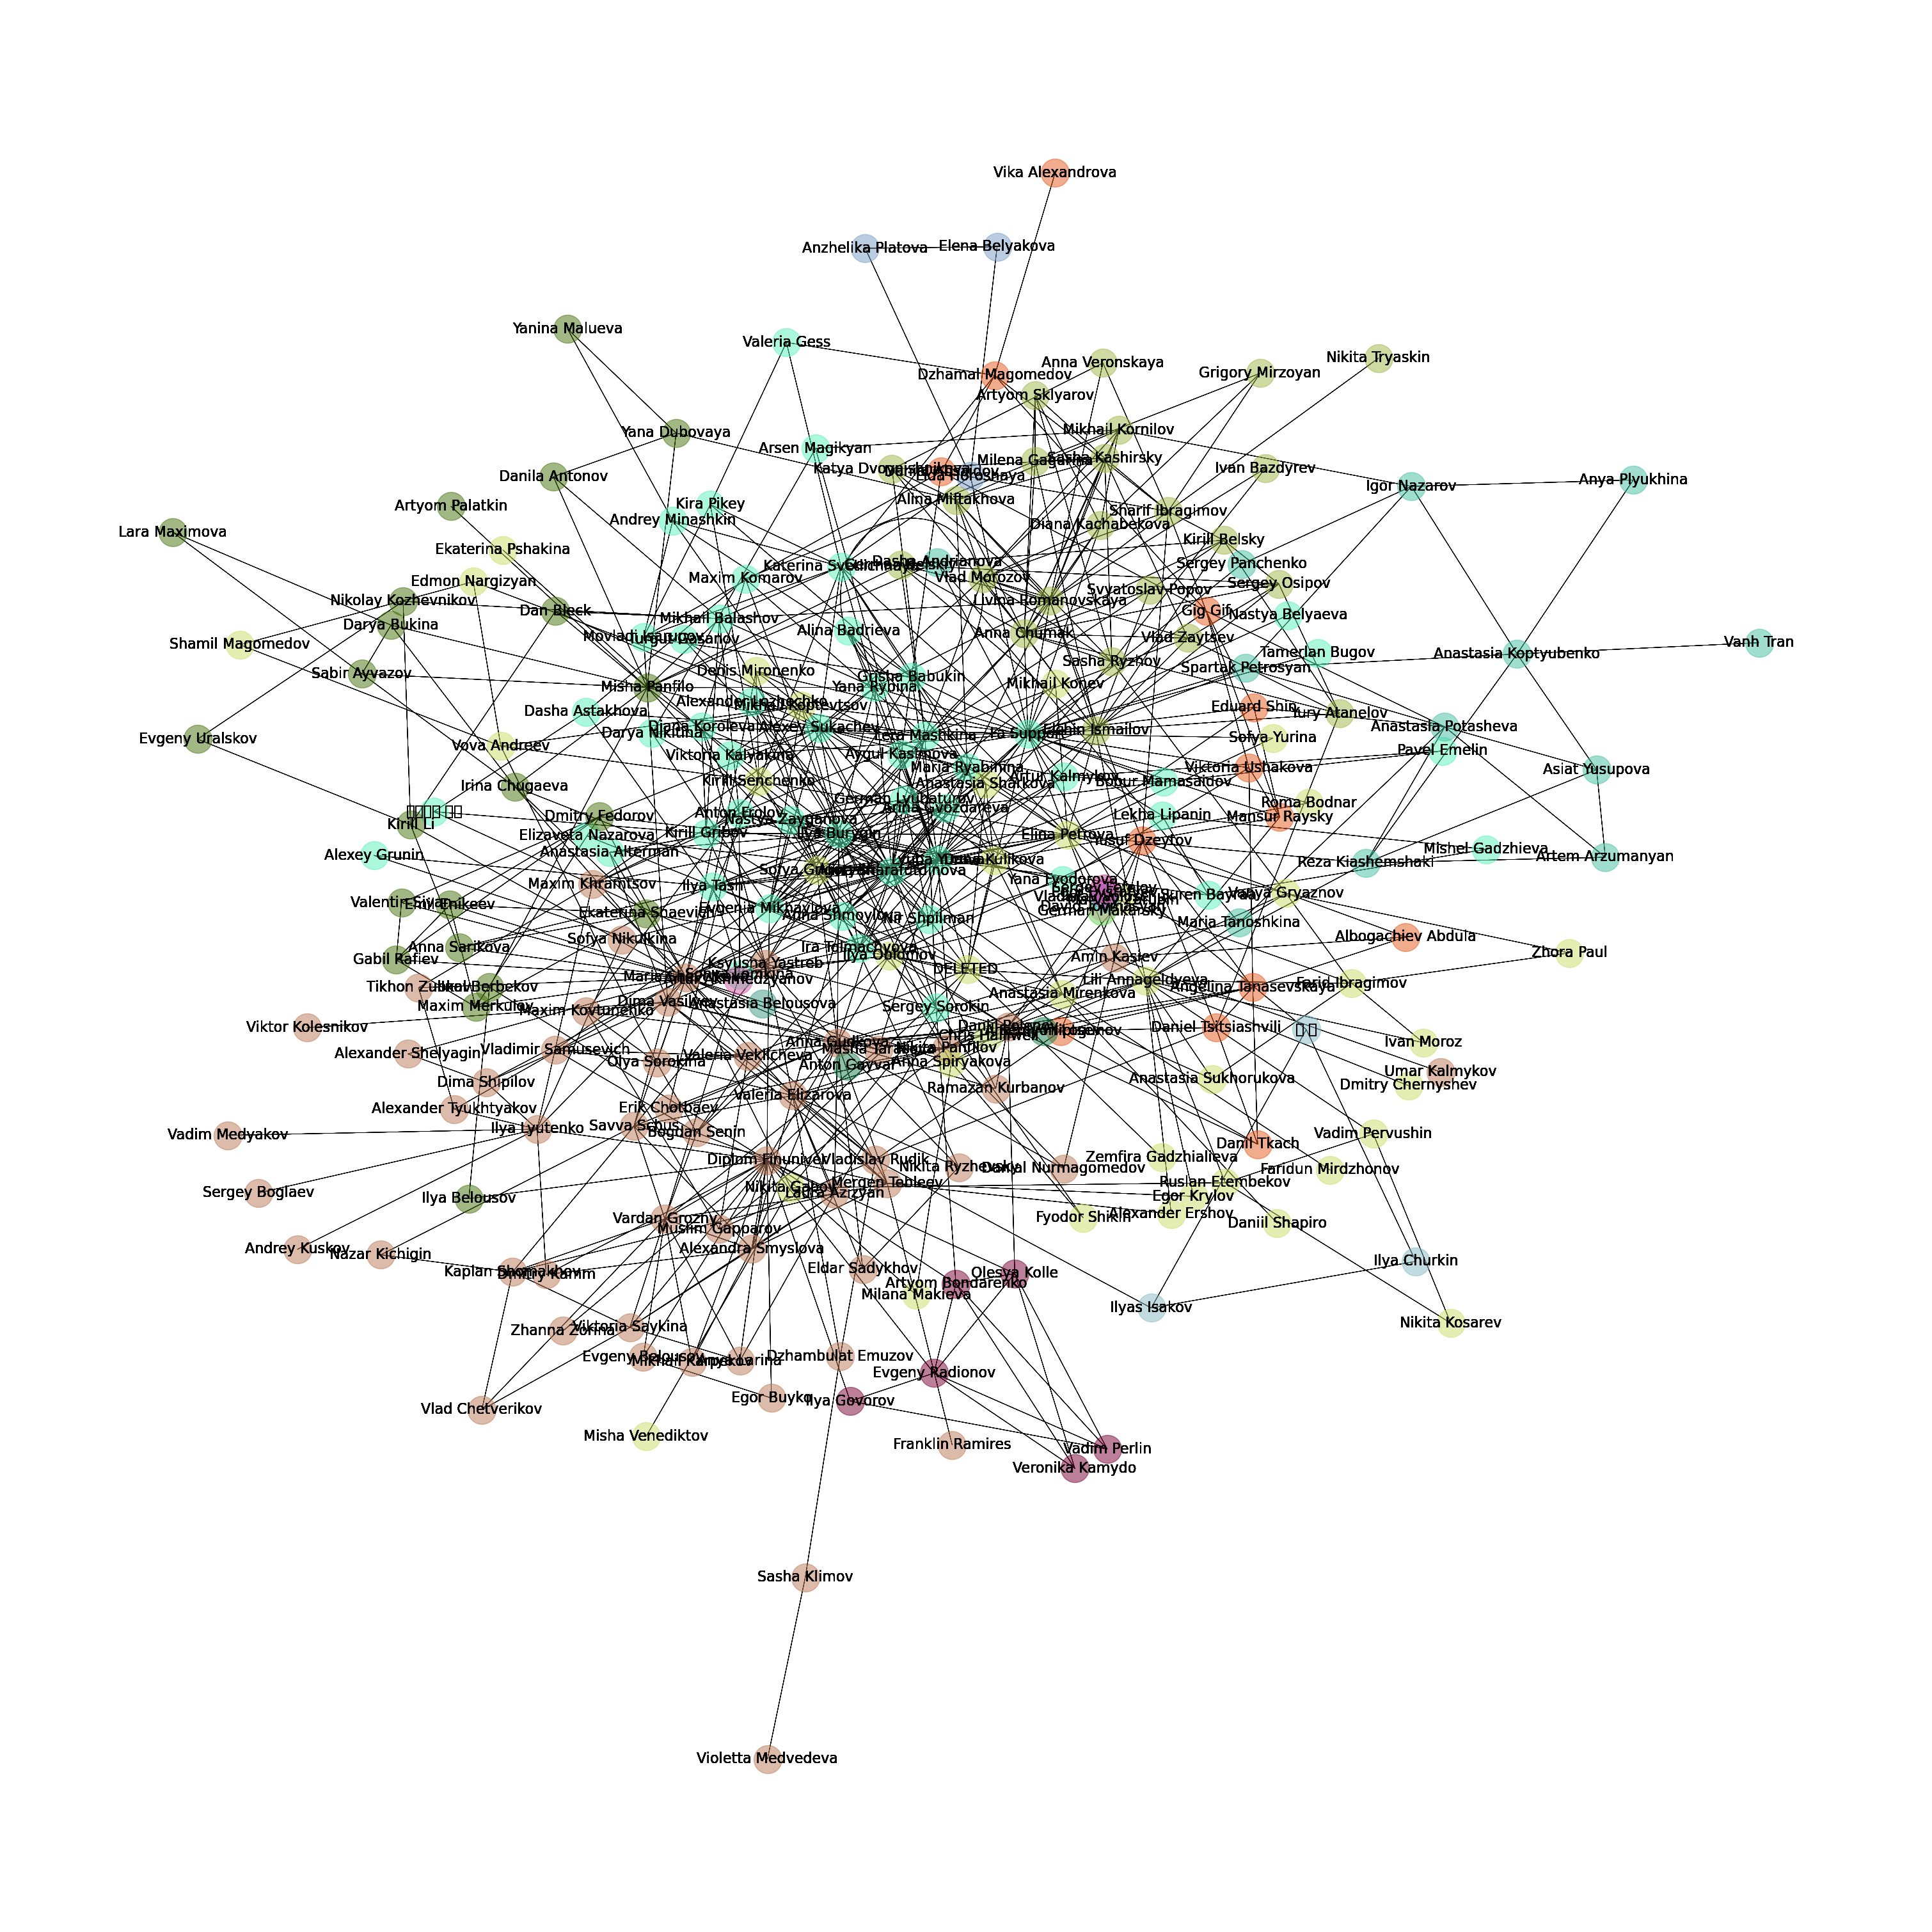

In [42]:
graph_plot(g_new)

### K-CORES

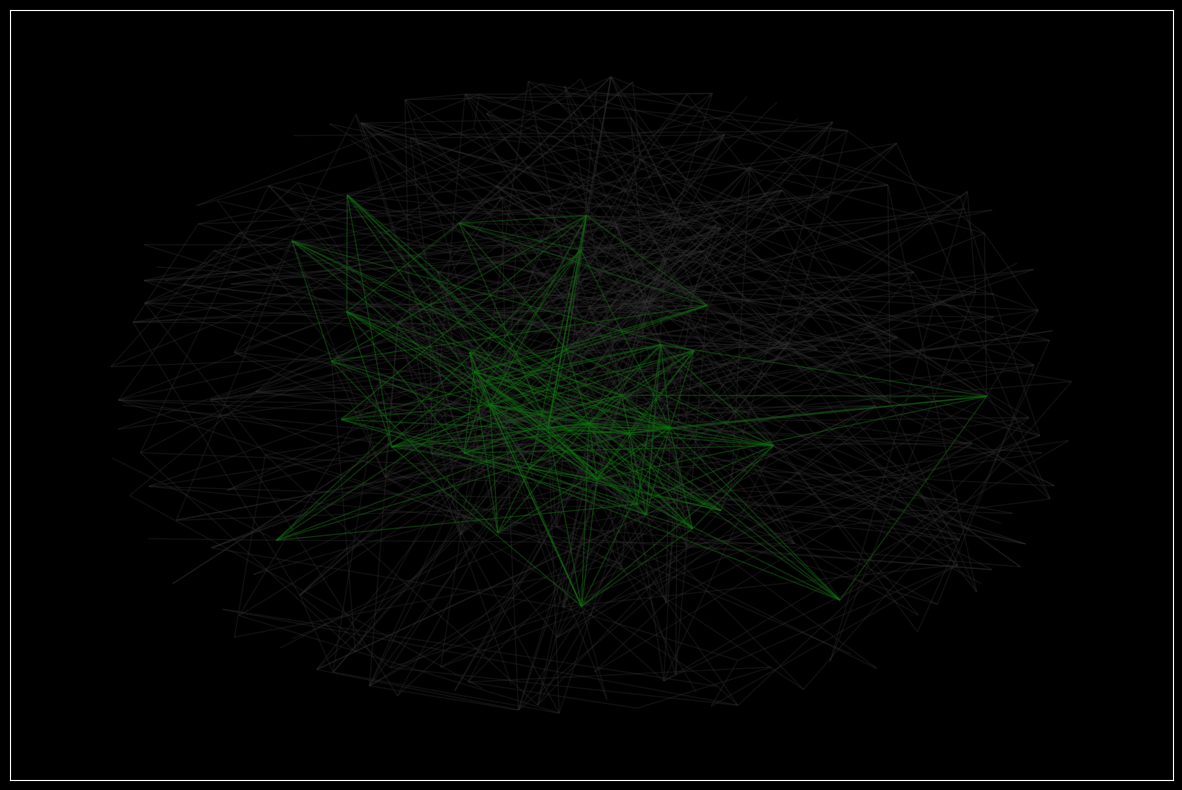

In [43]:
spring_g = copy.deepcopy(g_new)
spring_g.remove_edges_from(networkx.selfloop_edges(spring_g))
G_core_7 = networkx.k_core(spring_g, 6)
G_core_10 = networkx.k_core(spring_g, 7)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
plt.style.use('dark_background')
pos = networkx.spring_layout(spring_g, k=1)
networkx.draw_networkx(
    spring_g, pos=pos, node_size=0, edge_color="#333333", alpha=0.3, with_labels=False)
networkx.draw_networkx(
    G_core_7, pos=pos, node_size=0, edge_color="green", alpha=0.3, with_labels=False)
networkx.draw_networkx(
    G_core_10, pos=pos, node_size=0, edge_color="red", alpha=0.3, with_labels=False)

### Создание векторного встраивания пользовательского графа

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from karateclub import Graph2Vec

In [46]:
convertedgraph = networkx.convert_node_labels_to_integers(g_new)

In [47]:
embedding_model = Graph2Vec(dimensions=64)
embedding_model.fit([convertedgraph])
embeddingsframe = pd.DataFrame(embedding_model.get_embedding())

In [48]:
embeddingsframe

0         1         2         3         4         5         6   \
0  0.014331  0.016799  0.014321 -0.013748 -0.015221 -0.008122 -0.007682   

         7         8         9   ...        54        55        56        57  \
0  0.008259 -0.011955 -0.015168  ...  0.008085  0.015539  0.006549 -0.016651   

         58        59        60        61        62       63  
0 -0.004398  0.006437 -0.001028  0.008795  0.006326  0.00794  

[1 rows x 64 columns]

### Обучение модели

In [49]:
import xgboost as xgb
from pathlib import Path

In [50]:
def do_predict(frame):
    pred = classification_model.predict(embeddingsframe)[0]
    return pred

In [51]:
cur_path = Path().resolve()

In [52]:
classification_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, learning_rate = 0.05, n_estimators = 5000, early_stopping_rounds = 10)

In [53]:
classification_model.load_model(cur_path.joinpath('graph_bot_model.json'))

[18:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


In [54]:
pred = do_predict(embeddingsframe)
pred

'bot'